# Other Analysis Methods
### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from glob import glob

from random import seed
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(0)
rng = np.random.default_rng()

## 1. Basic Filters

In [2]:
filepath_acclerometer = "https://raw.githubusercontent.com/snuhcs/time-series-2022/master/Notebook/Data/accelerometer.csv"
filepath_gyroscope = "https://raw.githubusercontent.com/snuhcs/time-series-2022/master/Notebook/Data/gyroscope.csv"

#### Read Data with `pd.read_csv`
- `df.head()` will return top 5 rows.

In [3]:
df = pd.read_csv(filepath_acclerometer)
df.head()

,time,gFx,gFy,gFz,TgF
0,5.014,-0.6415,-0.6753,0.1064,0.938
1,5.014,-0.7915,-0.5771,0.1176,0.987
2,5.014,-0.7755,-0.5597,0.0701,0.959
3,5.015,-0.6608,-0.6224,0.0154,0.908
4,5.015,-0.6199,-0.6842,-0.0007,0.923


#### Plot data

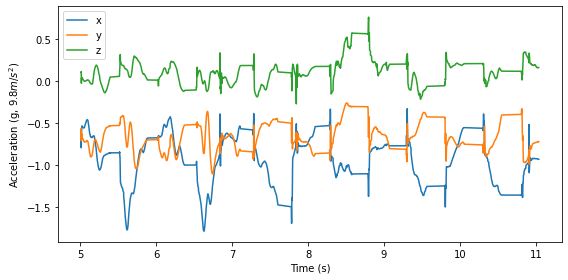

In [4]:
# Prepare X, Y data
X = df['time']
Y = df[['gFx', 'gFy', 'gFz']]

# Plot data
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(X, Y)
ax.legend('xyz')                               # 범례
ax.set_xlabel('Time (s)')                      # x축 라벨
ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')  # y축 라벨
fig.tight_layout()                             # 정렬
fig.show()

#### Plot Size of Acceleration

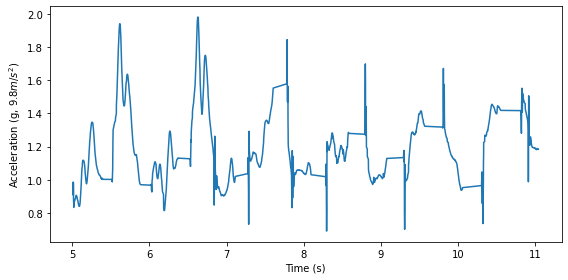

In [5]:
# Prepare X, Y data
X = df['time']
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Plot data
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(X, Y)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.tight_layout()
fig.show()

### 1.1. Moving average filter

In [6]:
def moving_average_filter(Y, window_size):
    # Original length
    length = Y.shape[0]
    
    # Filtered length
    filtered_length = length - (window_size - 1)
    
    # Get moving average
    Y_filtered = []
    for i in range(filtered_length):
        s = np.mean(Y[i:i+window_size])
        Y_filtered.append(s)

    return np.array(Y_filtered)

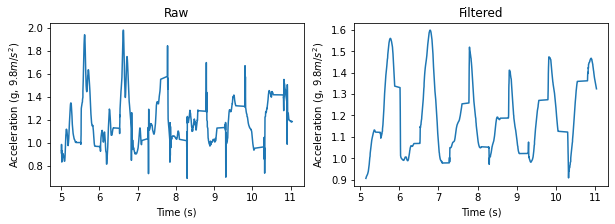

In [7]:
window_size = 100

# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y_filtered = moving_average_filter(Y, window_size)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(X, Y)
axes[1].plot(X[window_size - 1:], Y_filtered)

axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### 1.2. Median filter

In [8]:
def moving_average_filter(Y, window_size):
    # Original length
    length = Y.shape[0]
    
    # Filtered length
    filtered_length = length - (window_size - 1)
    
    # Get moving average
    Y_filtered = []
    for i in range(filtered_length):
        s = np.mean(Y[i:i+window_size])
        Y_filtered.append(s)

    return np.array(Y_filtered)


def median_filter(Y, window_size):
    # Original length
    length = Y.shape[0]

    # Filtered length
    filtered_length = length - (window_size - 1)

    # Get moving average
    Y_filtered = []
    for i in range(filtered_length):
      Y_window = Y[i:i + window_size]
      Y_filtered.append(np.median(Y_window))

    return np.array(Y_filtered)

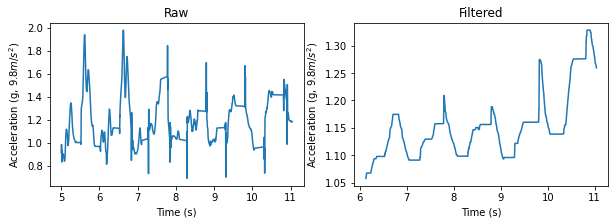

In [9]:
window_size = 500

# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y_filtered = median_filter(Y, window_size)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X[window_size - 1:], Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### 1.3. Exponentially weighted moving average filter

In [10]:
def ewma_filter(Y, alpha=0.5):
    Y_filtered = []
    
    for i in range(Y.shape[0]):
        filtered = 0
        if i == 0:
            filtered = Y[i]
        else:
            filtered = alpha * Y[i] + (1 - alpha) * Y_filtered[-1]
        Y_filtered.append(filtered)

    return np.array(Y_filtered)

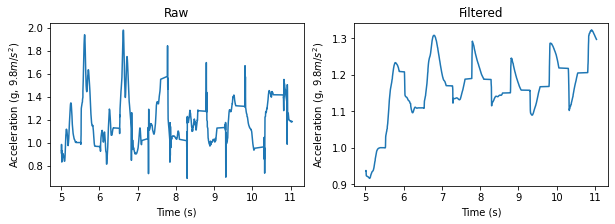

In [11]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X.iloc[-1] - X.iloc[0])
Y_filtered = ewma_filter(Y, 2/fs)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X, Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### 1.4. Low-pass filter using `scipy.signal.butter`

In [12]:
from scipy.signal import butter, lfilter

def low_pass_filter(data, threshold, order=5):
    b, a = butter(order, threshold, btype='low')
    return lfilter(b, a, data)

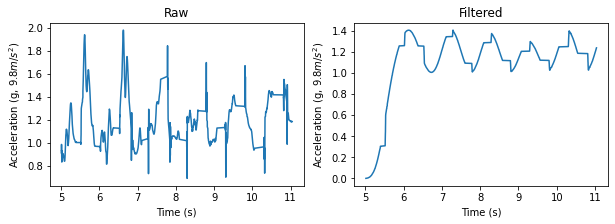

In [13]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X.iloc[-1] - X.iloc[0])
Y_filtered = low_pass_filter(Y, 2/fs)

# Plot data
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
axes[0].plot(X, Y)
axes[1].plot(X, Y_filtered)
axes[0].set_title('Raw')
axes[1].set_title('Filtered')
for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration (g, $9.8m/s^2$)')
fig.show()

### 1.5. Exercise: repeat the same process with gyroscope data

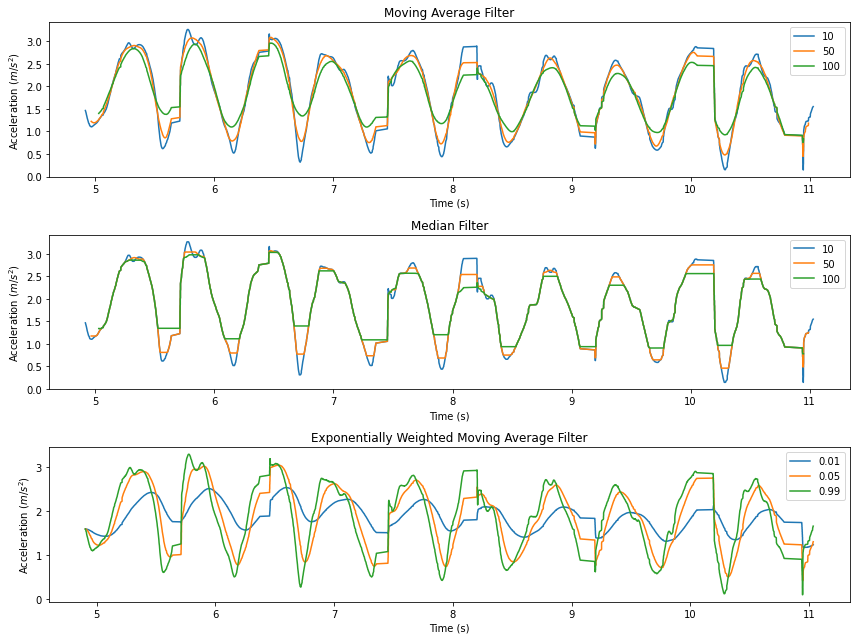

In [14]:
# Load data
df = pd.read_csv(filepath_gyroscope)
X = df['time']

# Get size of acceleration
Y = np.linalg.norm(df[['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']], axis=1)

# Filter data
window_sizes = [10, 50, 100]
alphas = [0.01, 0.05, 0.99]

Y_moving_average = [moving_average_filter(Y, window_size)
                    for window_size in window_sizes]
Y_median         = [median_filter(Y, window_size)
                    for window_size in window_sizes]
Y_ewma           = [ewma_filter(Y, alpha)
                    for alpha in alphas]

fig, axes = plt.subplots(3, 1, figsize=(12, 9))

def decorate_ax(ax, title):
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Acceleration ($m/s^2$)')
    ax.legend()

ax = axes[0]
for window_size, Y_filtered in zip(window_sizes, Y_moving_average):
    filtered_length = Y.shape[0] - (window_size - 1)
    shift = window_size // 2
    ax.plot(X[shift:shift + filtered_length], Y_filtered, label=str(window_size))
decorate_ax(ax, 'Moving Average Filter')

ax = axes[1]
for window_size, Y_filtered in zip(window_sizes, Y_median):
    filtered_length = Y.shape[0] - (window_size - 1)
    shift = window_size // 2
    ax.plot(X[shift:shift + filtered_length], Y_filtered, label=str(window_size))
decorate_ax(ax, 'Median Filter')

ax = axes[2]
for alpha, Y_filtered in zip(alphas, Y_ewma):
    ax.plot(X, Y_filtered, label=str(alpha))
decorate_ax(ax, 'Exponentially Weighted Moving Average Filter')

fig.tight_layout()
fig.show()

## 2. Frequency Domain Analysis

### 2.1. Visualize frequency components using FFT

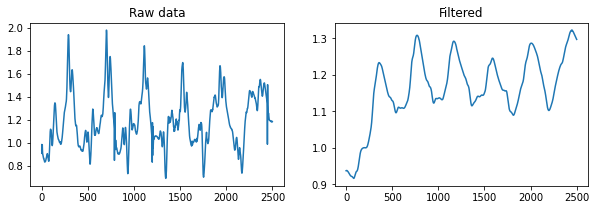

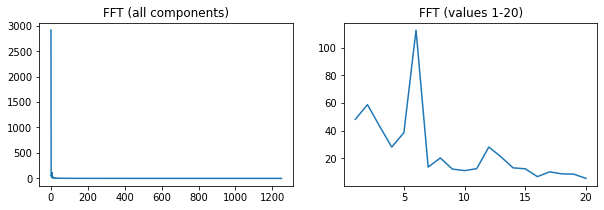

In [15]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time'].values

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
fs = X.shape[0] / (X[-1] - X[0])
Y_filtered = ewma_filter(Y, 2/fs)

fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)                # Plot all values after FFT
ax[1].plot(Y_filtered)       # Plot all values after FFT
ax[0].set_title("Raw data")
ax[1].set_title("Filtered")
fig.show()

fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(np.abs(np.fft.rfft(Y_filtered)))       # Plot all values after FFT
ax[1].plot(np.arange(1, 21), np.abs(np.fft.rfft(Y_filtered))[1:21]) # Plot 1~20 values after FFT
ax[0].set_title("FFT (all components)")
ax[1].set_title("FFT (values 1-20)")
fig.show()

### 2.2. Exercise: see the FFT results of different filters

In [16]:
# Load data
df = pd.read_csv(filepath_acclerometer)
X = df['time'].values

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data



# Plot data




### 2.3. Peak detection on frequency spectrum

In [17]:
def count_peaks_with_fft(Y):
    Y_fft = np.abs(np.fft.rfft(Y))[1:]
    count = np.argmax(Y_fft, axis=0) + 1
    return count

Detected peaks: 6


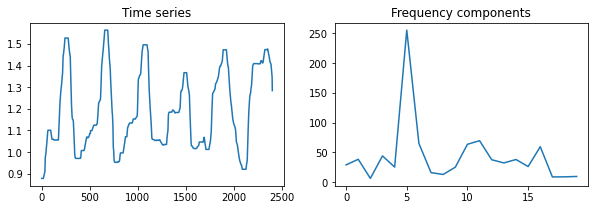

In [18]:
window_size = 100

# Load data
df = pd.read_csv(filepath_acclerometer)

# Get size of acceleration
Y = np.linalg.norm(df[['gFx', 'gFy', 'gFz']], axis=1)

# Filter data
Y = median_filter(Y, window_size)

# Count peaks
count = count_peaks_with_fft(Y)

# Plot data
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)
ax[0].set_title("Time series")

ax[1].plot(np.abs(np.fft.rfft(Y))[1:21]) # Plot 1~20 values after FFT
ax[1].set_title("Frequency components")
fig.show()

print(f'Detected peaks: {count}')

### 2.4. Exercise: repeat the same process with gyroscope data

In [19]:
df = pd.read_csv(filepath_gyroscope)
df.head()

,time,wx (rad/s),wy (rad/s),wz (rad/s)
0,4.904,0.03,0.29,-1.56
1,4.908,0.05,0.28,-1.53
2,4.909,0.07,0.28,-1.51
3,4.913,0.10,0.28,-1.48
4,4.914,0.12,0.27,-1.45


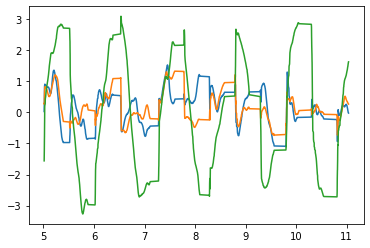

In [20]:
plt.plot(X, df[['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']])

Detected peaks: 10


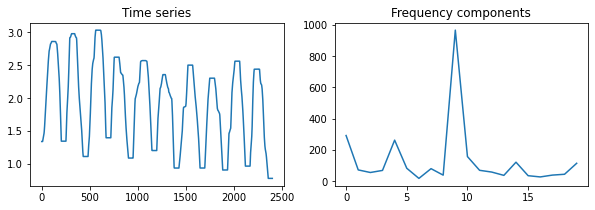

In [21]:
window_size = 100

# Load data
df = pd.read_csv(filepath_gyroscope)

# Get size of acceleration
Y = np.linalg.norm(df[['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']], axis=1)

# Filter data
Y = median_filter(Y, window_size)

# Count peaks
count = count_peaks_with_fft(Y)

# Plot data
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(Y)
ax[0].set_title("Time series")

ax[1].plot(np.abs(np.fft.rfft(Y))[1:21]) # Plot 1~20 values after FFT
ax[1].set_title("Frequency components")
fig.show()

print(f'Detected peaks: {count}')

## 3. Other Advanced Filters
### 3.1. Kalman Filter - Measure true level of 14.4V battery
> [Reference](https://github.com/tbmoon/kalman_filter/blob/master/Ch08.SimpleKalmanFilter/simple_kalman_filter.ipynb)

In [22]:
"""
System model of the Kalman Filter

x : State
z : Observation

x_k+1 = A @ x_k + w_k     w_k ~ N(0, Q)
z_k   = H @ x_k + v_k     v_k ~ N(0, R)
"""

# Initialization for system model.
A = 1  # x_t = x_t-1 + w_k
H = 1  # z_t = x_t   + v_k
Q = 0  # w_k ~ N(0, 0)
R = 4  # v_k ~ N(0, 4)

def get_volt():
    """Measure voltage."""
    v = np.random.normal(0, 2)   # v: measurement noise.
    volt_true = 14               # volt_true: True voltage [V].
    z_volt_meas = volt_true + v  # z_volt_meas: Measured Voltage [V] (observable).
    return z_volt_meas

def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable.
       Return Kalman Gain for Drawing.
    """
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P, K

#### Estimation

In [23]:
# Input parameters.
time_end = 10
dt = 0.2

# Initialization for estimation.
x_0 = 14.4
P_0 = 20
K_0 = 1

time = np.arange(0, time_end, dt)
n_samples = len(time)
volt_meas_save = np.zeros(n_samples)
volt_esti_save = np.zeros(n_samples)
P_save = np.zeros(n_samples)
K_save = np.zeros(n_samples)
x_esti, P, K = None, None, None
for i in range(n_samples):
    z_meas = get_volt()
    if i == 0:
        x_esti, P, K = x_0, P_0, K_0
    else:
        x_esti, P, K = kalman_filter(z_meas, x_esti, P)

    volt_meas_save[i] = z_meas
    volt_esti_save[i] = x_esti
    P_save[i] = P
    K_save[i] = K

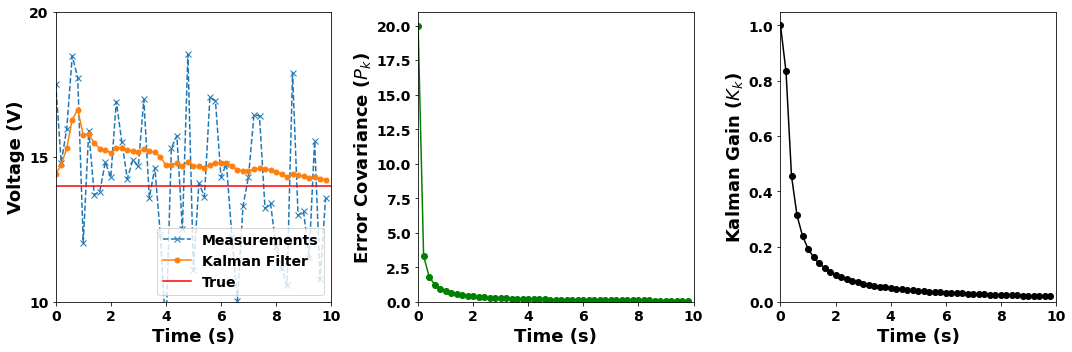

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fontsize = 18

ax = axes[0]
ax.plot(time, volt_meas_save, color='tab:blue', marker='x', linestyle='--', label='Measurements')
ax.plot(time, volt_esti_save, color='tab:orange', marker='o', label='Kalman Filter', markersize=5)
ax.axhline(y=14, linestyle='-', color='red', label='True')
ax.legend(loc='lower right', prop={'weight': 'bold', 'size': 14})
ax.set_xlabel('Time (s)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('Voltage (V)', fontsize=fontsize, fontweight='bold')
ax.set_yticks([10, 15, 20])
ax.set_xlim(0, 10)
ax.set_ylim(10, 20)

ax = axes[1]
ax.plot(time, P_save, 'go-')
ax.set_xlabel('Time (s)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('Error Covariance ($P_k$)', fontsize=fontsize, fontweight='bold')
ax.set_xlim(0, 10)
ax.set_ylim(0, ax.get_ylim()[1])

ax = axes[2]
ax.plot(time, K_save, 'ko-')
ax.set_xlabel('Time (s)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('Kalman Gain ($K_k$)', fontsize=fontsize, fontweight='bold')
ax.set_xlim(0, 10)
ax.set_ylim(0, ax.get_ylim()[1])

labels = axes[0].get_xticklabels() + axes[0].get_yticklabels() + \
    axes[1].get_xticklabels() + axes[1].get_yticklabels() + \
    axes[2].get_xticklabels() + axes[2].get_yticklabels()
[label.set_fontweight('bold') for label in labels]
[label.set_fontsize(14) for label in labels]

fig.tight_layout()

fig.show()